# Generating Fashion Designs Using A GAN

This project will create a Generative Adversarial Network (GAN) deep learning model to produce original new fashion designs using the [Fashion Mnist](https://github.com/zalandoresearch/fashion-mnist) data set.

## Setup

In [ ]:
# Make sure we have all the required modules imported into our environment

import sys
!{sys.executable} -m pip install -U tensorflow
!{sys.executable} -m pip install -U matplotlib

## Architecture

A GAN uses a Generator fed with random noise that generates fake images, and a discriminator trained on the dataset to detect if the image is real or fake. The output of the discriminator is fed back to the generator to give feedback on how well it is performing in producing fake images.

![GAN Diagram](https://i1.wp.com/rubikscode.net/wp-content/uploads/2018/12/Ganstructfinish-1.png?w=720&ssl=1)

In [11]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, UpSampling2D, Conv2D 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU

import matplotlib.pyplot as plt
import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images()

    def sample_images(self):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

## Train GAN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

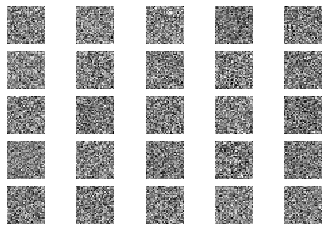

1 [D loss: 0.374844, acc.: 81.25%] [G loss: 0.448191]
2 [D loss: 0.367015, acc.: 68.75%] [G loss: 0.482024]
3 [D loss: 0.339829, acc.: 73.44%] [G loss: 0.582622]
4 [D loss: 0.365695, acc.: 70.31%] [G loss: 0.738106]
5 [D loss: 0.286749, acc.: 92.19%] [G loss: 0.880692]
6 [D loss: 0.259730, acc.: 92.19%] [G loss: 1.071362]
7 [D loss: 0.206657, acc.: 96.88%] [G loss: 1.240457]
8 [D loss: 0.168460, acc.: 100.00%] [G loss: 1.464564]
9 [D loss: 0.139675, acc.: 98.44%] [G loss: 1.558468]
10 [D loss: 0.158700, acc.: 96.88%] [G loss: 1.827186]
11 [D loss: 0.092688, acc.: 100.00%] [G loss: 1.929914]
12 [D loss: 0.096059, acc.: 100.00%] [G loss: 2.077684]
13 [D loss: 0.095421, acc.: 100.00%] [G loss: 2.144225]
14 [D loss: 0.075222, acc.: 98.44%] [G loss: 2.363974]
15 [D loss: 0.090233, acc.: 96.88%] [G loss: 2.587210]
16 [D loss: 0.097819, acc.: 98.44%] [G loss: 2.580577]
17 [D loss: 0.070397, acc.: 100.00%] [G loss: 2.648369]
18 [D loss: 0.045505, acc.: 100.00%] [G loss: 2.834361]
19 [D loss: 0

148 [D loss: 0.084727, acc.: 98.44%] [G loss: 3.395994]
149 [D loss: 0.140236, acc.: 95.31%] [G loss: 3.840054]
150 [D loss: 0.381349, acc.: 84.38%] [G loss: 3.420606]
151 [D loss: 0.185881, acc.: 90.62%] [G loss: 3.520459]
152 [D loss: 0.240587, acc.: 89.06%] [G loss: 3.052434]
153 [D loss: 0.213603, acc.: 89.06%] [G loss: 3.955837]
154 [D loss: 0.399870, acc.: 79.69%] [G loss: 2.738269]
155 [D loss: 0.356391, acc.: 81.25%] [G loss: 3.811610]
156 [D loss: 0.177575, acc.: 93.75%] [G loss: 3.310874]
157 [D loss: 0.247064, acc.: 89.06%] [G loss: 3.188148]
158 [D loss: 0.087150, acc.: 98.44%] [G loss: 3.434420]
159 [D loss: 0.197275, acc.: 95.31%] [G loss: 3.135249]
160 [D loss: 0.173786, acc.: 93.75%] [G loss: 3.112502]
161 [D loss: 0.405493, acc.: 82.81%] [G loss: 2.790675]
162 [D loss: 0.126582, acc.: 95.31%] [G loss: 3.590510]
163 [D loss: 0.141663, acc.: 98.44%] [G loss: 3.101774]
164 [D loss: 0.105566, acc.: 98.44%] [G loss: 3.070426]
165 [D loss: 0.199129, acc.: 92.19%] [G loss: 2.

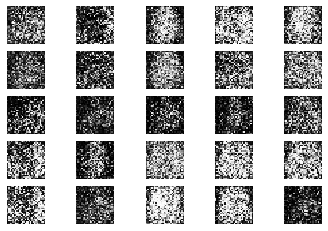

201 [D loss: 0.178748, acc.: 95.31%] [G loss: 3.401541]
202 [D loss: 0.250711, acc.: 92.19%] [G loss: 2.841161]
203 [D loss: 0.431327, acc.: 82.81%] [G loss: 2.775023]
204 [D loss: 0.216893, acc.: 90.62%] [G loss: 3.538368]
205 [D loss: 0.223895, acc.: 93.75%] [G loss: 3.265841]
206 [D loss: 0.179495, acc.: 96.88%] [G loss: 2.987224]
207 [D loss: 0.304562, acc.: 85.94%] [G loss: 3.182502]
208 [D loss: 0.131544, acc.: 98.44%] [G loss: 3.162994]
209 [D loss: 0.401211, acc.: 87.50%] [G loss: 3.521767]
210 [D loss: 0.524505, acc.: 75.00%] [G loss: 3.079124]
211 [D loss: 0.332002, acc.: 84.38%] [G loss: 3.317321]
212 [D loss: 0.341395, acc.: 87.50%] [G loss: 3.198519]
213 [D loss: 0.304092, acc.: 90.62%] [G loss: 3.176993]
214 [D loss: 0.105599, acc.: 98.44%] [G loss: 3.113657]
215 [D loss: 0.191071, acc.: 92.19%] [G loss: 3.017966]
216 [D loss: 0.347899, acc.: 87.50%] [G loss: 3.709807]
217 [D loss: 0.526187, acc.: 73.44%] [G loss: 2.885954]
218 [D loss: 0.133956, acc.: 95.31%] [G loss: 4.

348 [D loss: 0.732825, acc.: 59.38%] [G loss: 1.157679]
349 [D loss: 0.610856, acc.: 68.75%] [G loss: 1.224064]
350 [D loss: 0.730090, acc.: 54.69%] [G loss: 1.178603]
351 [D loss: 0.639143, acc.: 60.94%] [G loss: 1.306690]
352 [D loss: 0.827149, acc.: 48.44%] [G loss: 1.128094]
353 [D loss: 0.702488, acc.: 56.25%] [G loss: 1.096348]
354 [D loss: 0.623643, acc.: 65.62%] [G loss: 1.120919]
355 [D loss: 0.684859, acc.: 59.38%] [G loss: 1.026544]
356 [D loss: 0.745913, acc.: 65.62%] [G loss: 1.103604]
357 [D loss: 0.694520, acc.: 57.81%] [G loss: 1.236541]
358 [D loss: 0.704343, acc.: 59.38%] [G loss: 1.103697]
359 [D loss: 0.517588, acc.: 78.12%] [G loss: 1.239343]
360 [D loss: 0.655451, acc.: 60.94%] [G loss: 1.148599]
361 [D loss: 0.704238, acc.: 57.81%] [G loss: 0.971635]
362 [D loss: 0.653823, acc.: 56.25%] [G loss: 1.016709]
363 [D loss: 0.565529, acc.: 76.56%] [G loss: 1.220423]
364 [D loss: 0.612155, acc.: 65.62%] [G loss: 1.202950]
365 [D loss: 0.700489, acc.: 56.25%] [G loss: 1.

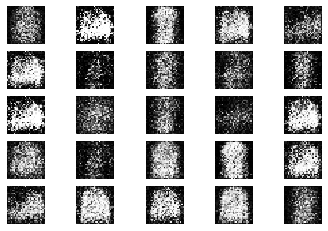

401 [D loss: 0.632267, acc.: 68.75%] [G loss: 1.161684]
402 [D loss: 0.486408, acc.: 76.56%] [G loss: 1.321216]
403 [D loss: 0.474799, acc.: 81.25%] [G loss: 1.295400]
404 [D loss: 0.669113, acc.: 59.38%] [G loss: 1.107961]
405 [D loss: 0.641529, acc.: 68.75%] [G loss: 1.045575]
406 [D loss: 0.576670, acc.: 68.75%] [G loss: 1.122298]
407 [D loss: 0.615041, acc.: 59.38%] [G loss: 1.156430]
408 [D loss: 0.528344, acc.: 76.56%] [G loss: 1.216555]
409 [D loss: 0.554531, acc.: 76.56%] [G loss: 1.149505]
410 [D loss: 0.529503, acc.: 79.69%] [G loss: 1.195596]
411 [D loss: 0.520803, acc.: 75.00%] [G loss: 1.290275]
412 [D loss: 0.603889, acc.: 68.75%] [G loss: 1.344889]
413 [D loss: 0.526859, acc.: 78.12%] [G loss: 1.276451]
414 [D loss: 0.637056, acc.: 65.62%] [G loss: 1.052029]
415 [D loss: 0.698884, acc.: 56.25%] [G loss: 1.037067]
416 [D loss: 0.660585, acc.: 71.88%] [G loss: 1.010196]
417 [D loss: 0.654103, acc.: 48.44%] [G loss: 1.024941]
418 [D loss: 0.582662, acc.: 71.88%] [G loss: 1.

549 [D loss: 0.530837, acc.: 81.25%] [G loss: 1.068528]
550 [D loss: 0.599822, acc.: 64.06%] [G loss: 0.970462]
551 [D loss: 0.644319, acc.: 53.12%] [G loss: 1.176555]
552 [D loss: 0.628052, acc.: 70.31%] [G loss: 1.000833]
553 [D loss: 0.585700, acc.: 62.50%] [G loss: 1.092747]
554 [D loss: 0.584633, acc.: 65.62%] [G loss: 1.158093]
555 [D loss: 0.638099, acc.: 64.06%] [G loss: 1.057315]
556 [D loss: 0.641752, acc.: 59.38%] [G loss: 1.014679]
557 [D loss: 0.631778, acc.: 67.19%] [G loss: 1.083648]
558 [D loss: 0.693041, acc.: 57.81%] [G loss: 1.075998]
559 [D loss: 0.581126, acc.: 71.88%] [G loss: 0.988715]
560 [D loss: 0.653827, acc.: 59.38%] [G loss: 0.919608]
561 [D loss: 0.659292, acc.: 68.75%] [G loss: 0.940105]
562 [D loss: 0.675587, acc.: 59.38%] [G loss: 1.043690]
563 [D loss: 0.617820, acc.: 62.50%] [G loss: 1.054931]
564 [D loss: 0.594444, acc.: 65.62%] [G loss: 1.078913]
565 [D loss: 0.608987, acc.: 65.62%] [G loss: 1.087530]
566 [D loss: 0.634094, acc.: 70.31%] [G loss: 0.

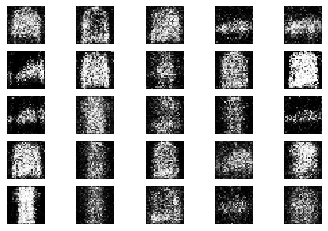

601 [D loss: 0.606695, acc.: 67.19%] [G loss: 1.015839]
602 [D loss: 0.632748, acc.: 64.06%] [G loss: 0.940587]
603 [D loss: 0.602880, acc.: 70.31%] [G loss: 1.059483]
604 [D loss: 0.645820, acc.: 64.06%] [G loss: 0.992318]
605 [D loss: 0.603287, acc.: 65.62%] [G loss: 0.977854]
606 [D loss: 0.617388, acc.: 68.75%] [G loss: 0.955014]
607 [D loss: 0.605668, acc.: 67.19%] [G loss: 1.023150]
608 [D loss: 0.596963, acc.: 68.75%] [G loss: 1.146076]
609 [D loss: 0.634102, acc.: 65.62%] [G loss: 1.030805]
610 [D loss: 0.639580, acc.: 67.19%] [G loss: 0.899092]
611 [D loss: 0.618587, acc.: 64.06%] [G loss: 0.886270]
612 [D loss: 0.644378, acc.: 64.06%] [G loss: 0.918584]
613 [D loss: 0.646775, acc.: 60.94%] [G loss: 1.064771]
614 [D loss: 0.632299, acc.: 64.06%] [G loss: 1.028229]
615 [D loss: 0.654925, acc.: 57.81%] [G loss: 0.936512]
616 [D loss: 0.617657, acc.: 67.19%] [G loss: 0.963390]
617 [D loss: 0.710786, acc.: 56.25%] [G loss: 1.024920]
618 [D loss: 0.638221, acc.: 65.62%] [G loss: 0.

748 [D loss: 0.629747, acc.: 65.62%] [G loss: 1.059924]
749 [D loss: 0.688304, acc.: 54.69%] [G loss: 0.901185]
750 [D loss: 0.600574, acc.: 73.44%] [G loss: 0.917123]
751 [D loss: 0.576980, acc.: 76.56%] [G loss: 1.011385]
752 [D loss: 0.553778, acc.: 70.31%] [G loss: 1.022904]
753 [D loss: 0.588863, acc.: 68.75%] [G loss: 1.019098]
754 [D loss: 0.606838, acc.: 65.62%] [G loss: 1.097492]
755 [D loss: 0.684339, acc.: 59.38%] [G loss: 1.072114]
756 [D loss: 0.609151, acc.: 67.19%] [G loss: 1.012533]
757 [D loss: 0.639327, acc.: 56.25%] [G loss: 0.982638]
758 [D loss: 0.693837, acc.: 46.88%] [G loss: 1.064926]
759 [D loss: 0.600664, acc.: 73.44%] [G loss: 0.943659]
760 [D loss: 0.666688, acc.: 53.12%] [G loss: 0.823376]
761 [D loss: 0.645962, acc.: 60.94%] [G loss: 0.812473]
762 [D loss: 0.546794, acc.: 75.00%] [G loss: 0.867026]
763 [D loss: 0.659954, acc.: 62.50%] [G loss: 0.829261]
764 [D loss: 0.671704, acc.: 51.56%] [G loss: 1.070805]
765 [D loss: 0.667409, acc.: 65.62%] [G loss: 1.

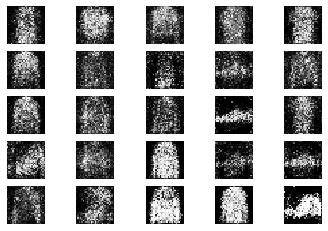

801 [D loss: 0.592631, acc.: 70.31%] [G loss: 0.963351]
802 [D loss: 0.622529, acc.: 67.19%] [G loss: 0.807104]
803 [D loss: 0.593457, acc.: 68.75%] [G loss: 0.890326]
804 [D loss: 0.622220, acc.: 65.62%] [G loss: 0.960156]
805 [D loss: 0.607613, acc.: 65.62%] [G loss: 1.067381]
806 [D loss: 0.597695, acc.: 67.19%] [G loss: 0.923723]
807 [D loss: 0.692196, acc.: 54.69%] [G loss: 0.894053]
808 [D loss: 0.553669, acc.: 75.00%] [G loss: 1.036743]
809 [D loss: 0.609238, acc.: 62.50%] [G loss: 0.938939]
810 [D loss: 0.824255, acc.: 37.50%] [G loss: 0.902476]
811 [D loss: 0.600092, acc.: 71.88%] [G loss: 0.992889]
812 [D loss: 0.634853, acc.: 64.06%] [G loss: 0.939922]
813 [D loss: 0.690875, acc.: 65.62%] [G loss: 0.922286]
814 [D loss: 0.599149, acc.: 64.06%] [G loss: 1.005987]
815 [D loss: 0.607440, acc.: 64.06%] [G loss: 0.896851]
816 [D loss: 0.668212, acc.: 60.94%] [G loss: 1.035008]
817 [D loss: 0.573185, acc.: 70.31%] [G loss: 0.970862]
818 [D loss: 0.733114, acc.: 54.69%] [G loss: 0.

948 [D loss: 0.666304, acc.: 54.69%] [G loss: 0.904249]
949 [D loss: 0.578448, acc.: 68.75%] [G loss: 0.998008]
950 [D loss: 0.604688, acc.: 65.62%] [G loss: 0.938660]
951 [D loss: 0.530368, acc.: 75.00%] [G loss: 0.882873]
952 [D loss: 0.616280, acc.: 60.94%] [G loss: 0.901807]
953 [D loss: 0.701026, acc.: 59.38%] [G loss: 0.919091]
954 [D loss: 0.672581, acc.: 54.69%] [G loss: 0.891855]
955 [D loss: 0.706024, acc.: 43.75%] [G loss: 0.879817]
956 [D loss: 0.659768, acc.: 67.19%] [G loss: 0.868700]
957 [D loss: 0.638690, acc.: 62.50%] [G loss: 0.990475]
958 [D loss: 0.635185, acc.: 65.62%] [G loss: 0.958602]
959 [D loss: 0.659862, acc.: 56.25%] [G loss: 0.998073]
960 [D loss: 0.606701, acc.: 64.06%] [G loss: 0.937428]
961 [D loss: 0.630813, acc.: 67.19%] [G loss: 0.878680]
962 [D loss: 0.665845, acc.: 54.69%] [G loss: 0.974350]
963 [D loss: 0.631009, acc.: 65.62%] [G loss: 0.996012]
964 [D loss: 0.660405, acc.: 65.62%] [G loss: 0.954058]
965 [D loss: 0.563596, acc.: 76.56%] [G loss: 0.

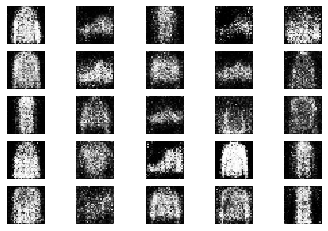

1001 [D loss: 0.681539, acc.: 59.38%] [G loss: 0.877897]
1002 [D loss: 0.634605, acc.: 67.19%] [G loss: 0.954626]
1003 [D loss: 0.599567, acc.: 68.75%] [G loss: 0.944006]
1004 [D loss: 0.644300, acc.: 64.06%] [G loss: 0.889736]
1005 [D loss: 0.640066, acc.: 59.38%] [G loss: 0.895099]
1006 [D loss: 0.628031, acc.: 65.62%] [G loss: 0.853300]
1007 [D loss: 0.617240, acc.: 67.19%] [G loss: 0.890920]
1008 [D loss: 0.655588, acc.: 64.06%] [G loss: 0.944011]
1009 [D loss: 0.607439, acc.: 64.06%] [G loss: 0.876399]
1010 [D loss: 0.652423, acc.: 64.06%] [G loss: 0.865633]
1011 [D loss: 0.611111, acc.: 62.50%] [G loss: 0.911508]
1012 [D loss: 0.669833, acc.: 59.38%] [G loss: 0.908543]
1013 [D loss: 0.669909, acc.: 68.75%] [G loss: 0.930008]
1014 [D loss: 0.633482, acc.: 60.94%] [G loss: 0.871284]
1015 [D loss: 0.634183, acc.: 67.19%] [G loss: 0.889283]
1016 [D loss: 0.679530, acc.: 54.69%] [G loss: 0.857493]
1017 [D loss: 0.640144, acc.: 68.75%] [G loss: 0.908279]
1018 [D loss: 0.583671, acc.: 7

1147 [D loss: 0.647846, acc.: 54.69%] [G loss: 0.881765]
1148 [D loss: 0.646417, acc.: 51.56%] [G loss: 0.853619]
1149 [D loss: 0.666523, acc.: 59.38%] [G loss: 0.898248]
1150 [D loss: 0.658757, acc.: 60.94%] [G loss: 0.806316]
1151 [D loss: 0.681872, acc.: 53.12%] [G loss: 0.859516]
1152 [D loss: 0.592237, acc.: 62.50%] [G loss: 0.822003]
1153 [D loss: 0.709324, acc.: 54.69%] [G loss: 0.780400]
1154 [D loss: 0.607648, acc.: 60.94%] [G loss: 0.873771]
1155 [D loss: 0.650640, acc.: 65.62%] [G loss: 0.845849]
1156 [D loss: 0.693554, acc.: 56.25%] [G loss: 0.907980]
1157 [D loss: 0.623566, acc.: 71.88%] [G loss: 0.932873]
1158 [D loss: 0.649179, acc.: 60.94%] [G loss: 1.022470]
1159 [D loss: 0.639161, acc.: 56.25%] [G loss: 0.927060]
1160 [D loss: 0.666930, acc.: 56.25%] [G loss: 0.906949]
1161 [D loss: 0.577151, acc.: 71.88%] [G loss: 0.870660]
1162 [D loss: 0.621744, acc.: 70.31%] [G loss: 0.901567]
1163 [D loss: 0.635577, acc.: 60.94%] [G loss: 0.858603]
1164 [D loss: 0.661131, acc.: 5

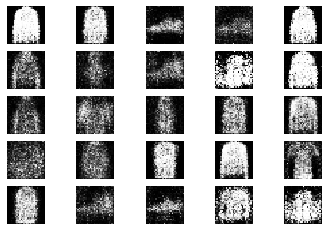

1201 [D loss: 0.601469, acc.: 71.88%] [G loss: 0.903471]
1202 [D loss: 0.623998, acc.: 64.06%] [G loss: 0.829912]
1203 [D loss: 0.630591, acc.: 67.19%] [G loss: 0.867259]
1204 [D loss: 0.554514, acc.: 68.75%] [G loss: 0.918174]
1205 [D loss: 0.601667, acc.: 65.62%] [G loss: 0.847712]
1206 [D loss: 0.666055, acc.: 57.81%] [G loss: 0.947383]
1207 [D loss: 0.542300, acc.: 71.88%] [G loss: 0.852608]
1208 [D loss: 0.670447, acc.: 56.25%] [G loss: 0.829987]
1209 [D loss: 0.575878, acc.: 76.56%] [G loss: 0.914087]
1210 [D loss: 0.634038, acc.: 60.94%] [G loss: 0.846282]
1211 [D loss: 0.634317, acc.: 57.81%] [G loss: 0.975750]
1212 [D loss: 0.662410, acc.: 57.81%] [G loss: 0.993236]
1213 [D loss: 0.643626, acc.: 59.38%] [G loss: 0.943579]
1214 [D loss: 0.637053, acc.: 64.06%] [G loss: 0.807465]
1215 [D loss: 0.609186, acc.: 64.06%] [G loss: 0.918944]
1216 [D loss: 0.610728, acc.: 73.44%] [G loss: 0.769340]
1217 [D loss: 0.715938, acc.: 48.44%] [G loss: 0.938580]
1218 [D loss: 0.544678, acc.: 7

1345 [D loss: 0.657816, acc.: 62.50%] [G loss: 0.901659]
1346 [D loss: 0.626060, acc.: 67.19%] [G loss: 0.908830]
1347 [D loss: 0.678622, acc.: 60.94%] [G loss: 0.916797]
1348 [D loss: 0.598732, acc.: 65.62%] [G loss: 0.911823]
1349 [D loss: 0.638952, acc.: 57.81%] [G loss: 0.865975]
1350 [D loss: 0.567548, acc.: 71.88%] [G loss: 0.904003]
1351 [D loss: 0.571874, acc.: 71.88%] [G loss: 0.902273]
1352 [D loss: 0.481563, acc.: 81.25%] [G loss: 0.888511]
1353 [D loss: 0.563546, acc.: 70.31%] [G loss: 0.977299]
1354 [D loss: 0.620513, acc.: 59.38%] [G loss: 0.875116]
1355 [D loss: 0.607938, acc.: 70.31%] [G loss: 0.934793]
1356 [D loss: 0.565842, acc.: 73.44%] [G loss: 0.952483]
1357 [D loss: 0.696151, acc.: 64.06%] [G loss: 0.970997]
1358 [D loss: 0.588493, acc.: 70.31%] [G loss: 0.883123]
1359 [D loss: 0.591060, acc.: 65.62%] [G loss: 0.866968]
1360 [D loss: 0.632783, acc.: 64.06%] [G loss: 0.904703]
1361 [D loss: 0.604008, acc.: 60.94%] [G loss: 0.837124]
1362 [D loss: 0.622062, acc.: 6

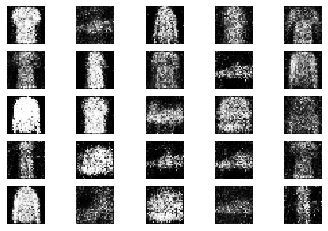

1401 [D loss: 0.637187, acc.: 64.06%] [G loss: 1.000393]
1402 [D loss: 0.646759, acc.: 62.50%] [G loss: 0.960636]
1403 [D loss: 0.566313, acc.: 73.44%] [G loss: 0.910852]
1404 [D loss: 0.642081, acc.: 65.62%] [G loss: 0.912373]
1405 [D loss: 0.572208, acc.: 76.56%] [G loss: 0.915556]
1406 [D loss: 0.707528, acc.: 56.25%] [G loss: 0.929374]
1407 [D loss: 0.629773, acc.: 65.62%] [G loss: 0.873699]
1408 [D loss: 0.568687, acc.: 67.19%] [G loss: 0.846505]
1409 [D loss: 0.643516, acc.: 62.50%] [G loss: 0.935083]
1410 [D loss: 0.687051, acc.: 57.81%] [G loss: 1.011168]
1411 [D loss: 0.544902, acc.: 75.00%] [G loss: 0.952215]
1412 [D loss: 0.591944, acc.: 68.75%] [G loss: 0.885494]
1413 [D loss: 0.562970, acc.: 73.44%] [G loss: 0.925428]
1414 [D loss: 0.635915, acc.: 64.06%] [G loss: 0.933984]
1415 [D loss: 0.629499, acc.: 62.50%] [G loss: 0.957716]
1416 [D loss: 0.715007, acc.: 54.69%] [G loss: 0.903586]
1417 [D loss: 0.583050, acc.: 71.88%] [G loss: 0.936717]
1418 [D loss: 0.646712, acc.: 6

1545 [D loss: 0.568083, acc.: 65.62%] [G loss: 0.958389]
1546 [D loss: 0.711756, acc.: 53.12%] [G loss: 0.932776]
1547 [D loss: 0.563390, acc.: 70.31%] [G loss: 0.929984]
1548 [D loss: 0.626739, acc.: 60.94%] [G loss: 0.878995]
1549 [D loss: 0.718447, acc.: 50.00%] [G loss: 0.804881]
1550 [D loss: 0.618145, acc.: 65.62%] [G loss: 0.920419]
1551 [D loss: 0.643655, acc.: 67.19%] [G loss: 0.889574]
1552 [D loss: 0.666317, acc.: 64.06%] [G loss: 0.988854]
1553 [D loss: 0.669731, acc.: 57.81%] [G loss: 0.896022]
1554 [D loss: 0.692332, acc.: 45.31%] [G loss: 1.015281]
1555 [D loss: 0.633200, acc.: 67.19%] [G loss: 0.856779]
1556 [D loss: 0.607071, acc.: 70.31%] [G loss: 0.972458]
1557 [D loss: 0.542612, acc.: 78.12%] [G loss: 1.086781]
1558 [D loss: 0.665782, acc.: 54.69%] [G loss: 1.032390]
1559 [D loss: 0.575806, acc.: 71.88%] [G loss: 0.902754]
1560 [D loss: 0.562602, acc.: 76.56%] [G loss: 0.898842]
1561 [D loss: 0.705802, acc.: 56.25%] [G loss: 0.951521]
1562 [D loss: 0.588719, acc.: 6

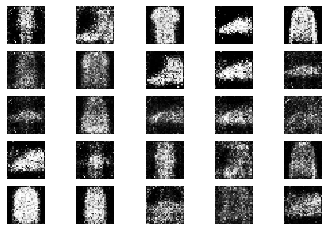

1601 [D loss: 0.614517, acc.: 67.19%] [G loss: 0.966111]
1602 [D loss: 0.624649, acc.: 65.62%] [G loss: 0.971439]
1603 [D loss: 0.583469, acc.: 60.94%] [G loss: 0.908506]
1604 [D loss: 0.489837, acc.: 81.25%] [G loss: 0.978653]
1605 [D loss: 0.679498, acc.: 53.12%] [G loss: 0.897065]
1606 [D loss: 0.635626, acc.: 70.31%] [G loss: 0.871320]
1607 [D loss: 0.580168, acc.: 71.88%] [G loss: 0.938024]
1608 [D loss: 0.573843, acc.: 73.44%] [G loss: 0.973712]
1609 [D loss: 0.581790, acc.: 64.06%] [G loss: 0.946873]
1610 [D loss: 0.583328, acc.: 68.75%] [G loss: 0.813576]
1611 [D loss: 0.503202, acc.: 79.69%] [G loss: 0.917592]
1612 [D loss: 0.537630, acc.: 71.88%] [G loss: 0.891164]
1613 [D loss: 0.641151, acc.: 57.81%] [G loss: 1.009182]
1614 [D loss: 0.653664, acc.: 62.50%] [G loss: 0.961760]
1615 [D loss: 0.593638, acc.: 62.50%] [G loss: 0.975725]
1616 [D loss: 0.577056, acc.: 71.88%] [G loss: 0.938666]
1617 [D loss: 0.582587, acc.: 71.88%] [G loss: 0.884268]
1618 [D loss: 0.686022, acc.: 5

1745 [D loss: 0.670697, acc.: 65.62%] [G loss: 0.953103]
1746 [D loss: 0.601569, acc.: 68.75%] [G loss: 0.878532]
1747 [D loss: 0.601243, acc.: 68.75%] [G loss: 0.964764]
1748 [D loss: 0.622004, acc.: 65.62%] [G loss: 0.975404]
1749 [D loss: 0.576741, acc.: 65.62%] [G loss: 0.970308]
1750 [D loss: 0.631399, acc.: 65.62%] [G loss: 0.909412]
1751 [D loss: 0.653307, acc.: 64.06%] [G loss: 0.799626]
1752 [D loss: 0.605558, acc.: 60.94%] [G loss: 0.868474]
1753 [D loss: 0.608918, acc.: 59.38%] [G loss: 0.956490]
1754 [D loss: 0.617030, acc.: 67.19%] [G loss: 0.897874]
1755 [D loss: 0.649694, acc.: 56.25%] [G loss: 0.865174]
1756 [D loss: 0.578046, acc.: 75.00%] [G loss: 0.892963]
1757 [D loss: 0.713670, acc.: 43.75%] [G loss: 0.936382]
1758 [D loss: 0.609207, acc.: 67.19%] [G loss: 0.862656]
1759 [D loss: 0.680690, acc.: 57.81%] [G loss: 0.832247]
1760 [D loss: 0.661031, acc.: 45.31%] [G loss: 0.896041]
1761 [D loss: 0.676728, acc.: 59.38%] [G loss: 0.830173]
1762 [D loss: 0.663939, acc.: 5

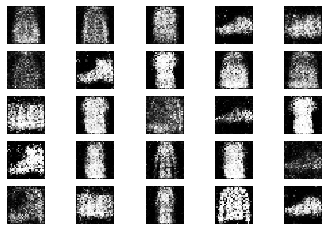

1801 [D loss: 0.642444, acc.: 67.19%] [G loss: 0.874575]
1802 [D loss: 0.598992, acc.: 62.50%] [G loss: 0.919349]
1803 [D loss: 0.706634, acc.: 57.81%] [G loss: 0.929933]
1804 [D loss: 0.637516, acc.: 67.19%] [G loss: 0.884493]
1805 [D loss: 0.653878, acc.: 56.25%] [G loss: 0.827030]
1806 [D loss: 0.675139, acc.: 62.50%] [G loss: 0.904389]
1807 [D loss: 0.688902, acc.: 56.25%] [G loss: 0.939769]
1808 [D loss: 0.570889, acc.: 70.31%] [G loss: 0.976968]
1809 [D loss: 0.621301, acc.: 62.50%] [G loss: 0.917693]
1810 [D loss: 0.611093, acc.: 64.06%] [G loss: 0.935633]
1811 [D loss: 0.576302, acc.: 68.75%] [G loss: 0.940329]
1812 [D loss: 0.607186, acc.: 68.75%] [G loss: 1.012461]
1813 [D loss: 0.653017, acc.: 54.69%] [G loss: 0.978262]
1814 [D loss: 0.538496, acc.: 75.00%] [G loss: 0.994726]
1815 [D loss: 0.722834, acc.: 56.25%] [G loss: 0.899123]
1816 [D loss: 0.605210, acc.: 67.19%] [G loss: 0.890852]
1817 [D loss: 0.631163, acc.: 65.62%] [G loss: 0.972326]
1818 [D loss: 0.579173, acc.: 7

1947 [D loss: 0.567408, acc.: 70.31%] [G loss: 0.938470]
1948 [D loss: 0.671718, acc.: 54.69%] [G loss: 0.895209]
1949 [D loss: 0.604686, acc.: 62.50%] [G loss: 0.958476]
1950 [D loss: 0.522846, acc.: 84.38%] [G loss: 1.011541]
1951 [D loss: 0.577722, acc.: 75.00%] [G loss: 0.962783]
1952 [D loss: 0.639682, acc.: 54.69%] [G loss: 0.961221]
1953 [D loss: 0.597336, acc.: 65.62%] [G loss: 0.990856]
1954 [D loss: 0.628854, acc.: 62.50%] [G loss: 0.980662]
1955 [D loss: 0.624386, acc.: 59.38%] [G loss: 0.929421]
1956 [D loss: 0.613619, acc.: 71.88%] [G loss: 0.951773]
1957 [D loss: 0.653646, acc.: 57.81%] [G loss: 0.871325]
1958 [D loss: 0.616020, acc.: 64.06%] [G loss: 0.910881]
1959 [D loss: 0.633557, acc.: 67.19%] [G loss: 0.842730]
1960 [D loss: 0.613131, acc.: 59.38%] [G loss: 0.941779]
1961 [D loss: 0.603991, acc.: 67.19%] [G loss: 0.931466]
1962 [D loss: 0.688062, acc.: 62.50%] [G loss: 0.967749]
1963 [D loss: 0.605449, acc.: 67.19%] [G loss: 0.919274]
1964 [D loss: 0.701006, acc.: 5

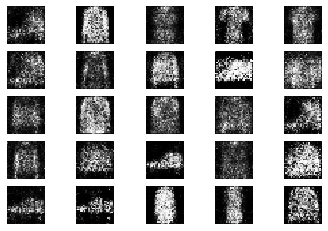

2001 [D loss: 0.649306, acc.: 56.25%] [G loss: 0.975693]
2002 [D loss: 0.617152, acc.: 65.62%] [G loss: 0.984745]
2003 [D loss: 0.536441, acc.: 75.00%] [G loss: 1.046338]
2004 [D loss: 0.654794, acc.: 62.50%] [G loss: 1.016617]
2005 [D loss: 0.635678, acc.: 64.06%] [G loss: 0.845297]
2006 [D loss: 0.621267, acc.: 64.06%] [G loss: 0.969158]
2007 [D loss: 0.604503, acc.: 73.44%] [G loss: 0.879278]
2008 [D loss: 0.652672, acc.: 54.69%] [G loss: 0.886586]
2009 [D loss: 0.589482, acc.: 71.88%] [G loss: 0.822184]
2010 [D loss: 0.630710, acc.: 68.75%] [G loss: 0.876245]
2011 [D loss: 0.642593, acc.: 67.19%] [G loss: 0.860925]
2012 [D loss: 0.582056, acc.: 62.50%] [G loss: 0.891976]
2013 [D loss: 0.653901, acc.: 59.38%] [G loss: 0.899358]
2014 [D loss: 0.614385, acc.: 70.31%] [G loss: 0.857339]
2015 [D loss: 0.685493, acc.: 50.00%] [G loss: 0.936172]
2016 [D loss: 0.578111, acc.: 68.75%] [G loss: 0.945534]
2017 [D loss: 0.668406, acc.: 60.94%] [G loss: 1.026006]
2018 [D loss: 0.610214, acc.: 7

2145 [D loss: 0.615822, acc.: 65.62%] [G loss: 0.935331]
2146 [D loss: 0.510136, acc.: 81.25%] [G loss: 0.942352]
2147 [D loss: 0.619678, acc.: 68.75%] [G loss: 0.993396]
2148 [D loss: 0.669675, acc.: 64.06%] [G loss: 0.974867]
2149 [D loss: 0.551045, acc.: 76.56%] [G loss: 0.942196]
2150 [D loss: 0.599759, acc.: 71.88%] [G loss: 1.011818]
2151 [D loss: 0.657210, acc.: 54.69%] [G loss: 0.863858]
2152 [D loss: 0.678659, acc.: 59.38%] [G loss: 0.770969]
2153 [D loss: 0.625139, acc.: 62.50%] [G loss: 0.865035]
2154 [D loss: 0.621889, acc.: 57.81%] [G loss: 0.866769]
2155 [D loss: 0.533676, acc.: 75.00%] [G loss: 0.931004]
2156 [D loss: 0.611841, acc.: 68.75%] [G loss: 0.948864]
2157 [D loss: 0.608210, acc.: 65.62%] [G loss: 0.954599]
2158 [D loss: 0.570664, acc.: 71.88%] [G loss: 1.025488]
2159 [D loss: 0.596757, acc.: 73.44%] [G loss: 0.999589]
2160 [D loss: 0.599375, acc.: 62.50%] [G loss: 1.059095]
2161 [D loss: 0.615611, acc.: 68.75%] [G loss: 0.999743]
2162 [D loss: 0.667060, acc.: 5

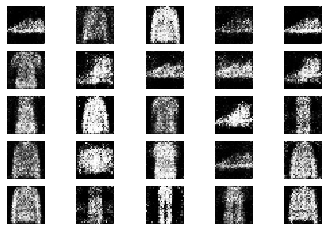

2201 [D loss: 0.643804, acc.: 57.81%] [G loss: 0.961487]
2202 [D loss: 0.620691, acc.: 73.44%] [G loss: 1.011719]
2203 [D loss: 0.613598, acc.: 67.19%] [G loss: 1.059312]
2204 [D loss: 0.547072, acc.: 75.00%] [G loss: 1.014932]
2205 [D loss: 0.630124, acc.: 57.81%] [G loss: 0.969390]
2206 [D loss: 0.652738, acc.: 65.62%] [G loss: 0.915974]
2207 [D loss: 0.614356, acc.: 67.19%] [G loss: 0.916747]
2208 [D loss: 0.618159, acc.: 62.50%] [G loss: 0.875638]
2209 [D loss: 0.543491, acc.: 79.69%] [G loss: 0.975506]
2210 [D loss: 0.586382, acc.: 73.44%] [G loss: 0.953832]
2211 [D loss: 0.552556, acc.: 71.88%] [G loss: 1.013234]
2212 [D loss: 0.669942, acc.: 59.38%] [G loss: 0.983053]
2213 [D loss: 0.659287, acc.: 57.81%] [G loss: 0.939328]
2214 [D loss: 0.592957, acc.: 76.56%] [G loss: 0.924469]
2215 [D loss: 0.591609, acc.: 67.19%] [G loss: 0.873139]
2216 [D loss: 0.633874, acc.: 62.50%] [G loss: 0.911334]
2217 [D loss: 0.609102, acc.: 68.75%] [G loss: 0.914173]
2218 [D loss: 0.673532, acc.: 5

2345 [D loss: 0.582015, acc.: 70.31%] [G loss: 0.976046]
2346 [D loss: 0.616386, acc.: 60.94%] [G loss: 1.028774]
2347 [D loss: 0.658284, acc.: 59.38%] [G loss: 0.965365]
2348 [D loss: 0.555675, acc.: 73.44%] [G loss: 0.925858]
2349 [D loss: 0.597711, acc.: 70.31%] [G loss: 0.918289]
2350 [D loss: 0.654542, acc.: 64.06%] [G loss: 0.946956]
2351 [D loss: 0.578189, acc.: 60.94%] [G loss: 0.864634]
2352 [D loss: 0.627343, acc.: 67.19%] [G loss: 0.888946]
2353 [D loss: 0.543866, acc.: 81.25%] [G loss: 1.007057]
2354 [D loss: 0.605673, acc.: 68.75%] [G loss: 0.973708]
2355 [D loss: 0.558544, acc.: 65.62%] [G loss: 0.939421]
2356 [D loss: 0.590924, acc.: 67.19%] [G loss: 0.895108]
2357 [D loss: 0.616172, acc.: 65.62%] [G loss: 0.910832]
2358 [D loss: 0.547840, acc.: 76.56%] [G loss: 0.987571]
2359 [D loss: 0.624784, acc.: 64.06%] [G loss: 0.969096]
2360 [D loss: 0.753396, acc.: 46.88%] [G loss: 0.965591]
2361 [D loss: 0.657779, acc.: 57.81%] [G loss: 0.893748]
2362 [D loss: 0.595231, acc.: 6

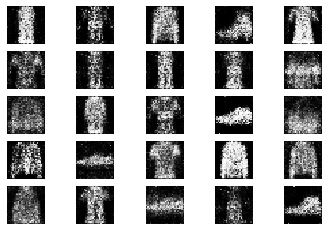

2401 [D loss: 0.668496, acc.: 59.38%] [G loss: 0.934232]
2402 [D loss: 0.667660, acc.: 51.56%] [G loss: 0.878147]
2403 [D loss: 0.671044, acc.: 59.38%] [G loss: 0.961973]
2404 [D loss: 0.671472, acc.: 50.00%] [G loss: 0.937463]
2405 [D loss: 0.615070, acc.: 62.50%] [G loss: 0.996102]
2406 [D loss: 0.579869, acc.: 76.56%] [G loss: 1.048005]
2407 [D loss: 0.647588, acc.: 62.50%] [G loss: 1.008814]
2408 [D loss: 0.648572, acc.: 62.50%] [G loss: 0.911134]
2409 [D loss: 0.597166, acc.: 73.44%] [G loss: 0.994174]
2410 [D loss: 0.666623, acc.: 57.81%] [G loss: 1.045264]
2411 [D loss: 0.559741, acc.: 68.75%] [G loss: 0.941684]
2412 [D loss: 0.546911, acc.: 75.00%] [G loss: 1.069290]
2413 [D loss: 0.530101, acc.: 76.56%] [G loss: 0.966265]
2414 [D loss: 0.665287, acc.: 62.50%] [G loss: 0.886010]
2415 [D loss: 0.706822, acc.: 57.81%] [G loss: 0.995218]
2416 [D loss: 0.529600, acc.: 79.69%] [G loss: 1.009171]
2417 [D loss: 0.724505, acc.: 53.12%] [G loss: 0.989285]
2418 [D loss: 0.707151, acc.: 5

2545 [D loss: 0.631101, acc.: 64.06%] [G loss: 0.971995]
2546 [D loss: 0.572711, acc.: 68.75%] [G loss: 0.985556]
2547 [D loss: 0.626016, acc.: 62.50%] [G loss: 0.898400]
2548 [D loss: 0.690659, acc.: 51.56%] [G loss: 0.973001]
2549 [D loss: 0.630049, acc.: 67.19%] [G loss: 0.946177]
2550 [D loss: 0.581432, acc.: 67.19%] [G loss: 0.950540]
2551 [D loss: 0.647404, acc.: 59.38%] [G loss: 0.878810]
2552 [D loss: 0.628498, acc.: 70.31%] [G loss: 0.924700]
2553 [D loss: 0.632311, acc.: 59.38%] [G loss: 0.909024]
2554 [D loss: 0.646661, acc.: 56.25%] [G loss: 0.920747]
2555 [D loss: 0.618577, acc.: 71.88%] [G loss: 0.964161]
2556 [D loss: 0.570000, acc.: 68.75%] [G loss: 1.010108]
2557 [D loss: 0.603370, acc.: 65.62%] [G loss: 0.936082]
2558 [D loss: 0.668848, acc.: 54.69%] [G loss: 0.933203]
2559 [D loss: 0.574316, acc.: 73.44%] [G loss: 1.008419]
2560 [D loss: 0.643881, acc.: 60.94%] [G loss: 1.120840]
2561 [D loss: 0.634532, acc.: 62.50%] [G loss: 0.956992]
2562 [D loss: 0.646921, acc.: 5

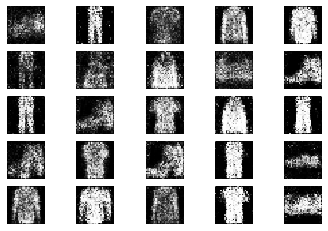

2601 [D loss: 0.629718, acc.: 65.62%] [G loss: 0.891825]
2602 [D loss: 0.634253, acc.: 64.06%] [G loss: 0.890801]
2603 [D loss: 0.691524, acc.: 51.56%] [G loss: 0.904819]
2604 [D loss: 0.565275, acc.: 71.88%] [G loss: 0.944000]
2605 [D loss: 0.548025, acc.: 70.31%] [G loss: 1.056204]
2606 [D loss: 0.650851, acc.: 62.50%] [G loss: 0.984174]
2607 [D loss: 0.722180, acc.: 54.69%] [G loss: 0.970972]
2608 [D loss: 0.591075, acc.: 67.19%] [G loss: 1.003031]
2609 [D loss: 0.603102, acc.: 67.19%] [G loss: 0.941579]
2610 [D loss: 0.565896, acc.: 67.19%] [G loss: 0.960162]
2611 [D loss: 0.676440, acc.: 64.06%] [G loss: 0.853658]
2612 [D loss: 0.650568, acc.: 65.62%] [G loss: 0.973773]
2613 [D loss: 0.611637, acc.: 65.62%] [G loss: 0.968356]
2614 [D loss: 0.677904, acc.: 65.62%] [G loss: 0.955572]
2615 [D loss: 0.639880, acc.: 60.94%] [G loss: 0.912279]
2616 [D loss: 0.643214, acc.: 59.38%] [G loss: 0.984877]
2617 [D loss: 0.575363, acc.: 76.56%] [G loss: 0.922602]
2618 [D loss: 0.570774, acc.: 7

2747 [D loss: 0.661060, acc.: 62.50%] [G loss: 0.958605]
2748 [D loss: 0.603765, acc.: 70.31%] [G loss: 1.020988]
2749 [D loss: 0.595001, acc.: 67.19%] [G loss: 0.968492]
2750 [D loss: 0.660198, acc.: 64.06%] [G loss: 1.065015]
2751 [D loss: 0.606001, acc.: 67.19%] [G loss: 0.959083]
2752 [D loss: 0.623794, acc.: 70.31%] [G loss: 0.932762]
2753 [D loss: 0.586151, acc.: 73.44%] [G loss: 0.945770]
2754 [D loss: 0.536081, acc.: 81.25%] [G loss: 1.035110]
2755 [D loss: 0.666094, acc.: 60.94%] [G loss: 1.009577]
2756 [D loss: 0.569547, acc.: 70.31%] [G loss: 0.937276]
2757 [D loss: 0.688085, acc.: 59.38%] [G loss: 0.978906]
2758 [D loss: 0.682707, acc.: 54.69%] [G loss: 0.969349]
2759 [D loss: 0.649191, acc.: 64.06%] [G loss: 0.992283]
2760 [D loss: 0.674080, acc.: 57.81%] [G loss: 0.987484]
2761 [D loss: 0.659894, acc.: 59.38%] [G loss: 0.876146]
2762 [D loss: 0.658442, acc.: 54.69%] [G loss: 0.912707]
2763 [D loss: 0.610218, acc.: 68.75%] [G loss: 0.918379]
2764 [D loss: 0.700477, acc.: 5

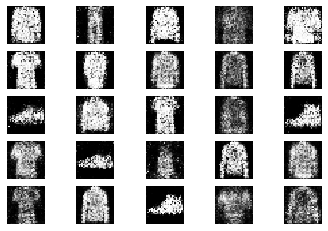

2801 [D loss: 0.657557, acc.: 53.12%] [G loss: 1.039413]
2802 [D loss: 0.633733, acc.: 65.62%] [G loss: 0.977907]
2803 [D loss: 0.594654, acc.: 64.06%] [G loss: 0.948630]
2804 [D loss: 0.667952, acc.: 64.06%] [G loss: 0.894491]
2805 [D loss: 0.638035, acc.: 62.50%] [G loss: 0.969657]
2806 [D loss: 0.591165, acc.: 56.25%] [G loss: 1.009388]
2807 [D loss: 0.646524, acc.: 68.75%] [G loss: 1.078115]
2808 [D loss: 0.543530, acc.: 76.56%] [G loss: 0.982924]
2809 [D loss: 0.611282, acc.: 65.62%] [G loss: 0.976140]
2810 [D loss: 0.578555, acc.: 67.19%] [G loss: 0.906485]
2811 [D loss: 0.644400, acc.: 56.25%] [G loss: 0.944598]
2812 [D loss: 0.556522, acc.: 79.69%] [G loss: 0.972371]
2813 [D loss: 0.662411, acc.: 54.69%] [G loss: 0.989989]
2814 [D loss: 0.594470, acc.: 68.75%] [G loss: 1.003655]
2815 [D loss: 0.617819, acc.: 56.25%] [G loss: 1.045486]
2816 [D loss: 0.559580, acc.: 68.75%] [G loss: 1.006658]
2817 [D loss: 0.639298, acc.: 57.81%] [G loss: 0.961135]
2818 [D loss: 0.580967, acc.: 6

In [ ]:
gan = GAN()
gan.train(epochs=3000, batch_size=32, sample_interval=200)

## Test GAN

In [10]:
gan.sample_images()

TypeError: sample_images() missing 1 required positional argument: 'epoch'

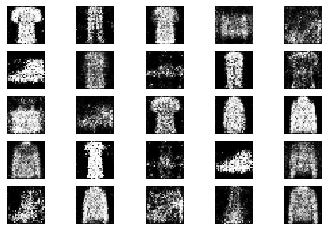

In [7]:
gan.sample_images(2)

## Conclusion

In this project we've built a simple GAN that can train on images to produce new ones.

Considering the original dataset is very low quality images of fashion items, we cannot expect the GAN to product clear, colourful images as we would want in a production version of this GAN. However you can see from the tests above the GAN is able to produce images that resemble clothing items such as t-shirts and shoes.

Running the GAN training for more iterations should improve the quality of the output images as well.

## References

* https://github.com/R-Suresh/GAN_fashion_MNIST/blob/master/gan.py